In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Introduction tot data assimilation
## Practical session Day 2 : Tangent and adjoint models

### D2.3 Adjoint logistic model

We consider the  logistic model:
$$
\begin{array}{lr}
y'(t)=\alpha y(t)(1-y(t)/K),& t\in[0,T]\\
y(t=0)=y_0,& t=0.
\end{array}$$

for some given constants $\alpha>0$ and $K>0$. The initial population is $y_0>0$.
In this exercise we  fix the time interval $[0,T] = [0,200]$. The values of $y$ are computed on 1000 points equally spaced in this interval (option $t\_eval$ of $t\_solve\_{ivp}$. The parameters are $\theta=(\alpha,K)$.

We consider observations of the population
$$y_{obs}(t_i)=y(\theta^*)(t_i)+n,$$
where $n$ is the realization of gaussian random noise with variance $\sigma^2$, and $\theta^*$ is the (true) value of the parameters.
The following cost function is to be minimized:
$$j(\theta)=\dfrac{1}{2}\sum_i (y(\theta)(t_i)-y_{obs}(t_i))^2.$$


- Calculate the gradient of $j$ using the adjoint method.
	
- Compute the adjoint state. Note: since it is a backwards ODE the solution using {\tt solve\_ivp} has to be carefully written (indicate the integration bounds $[T,0]$ in this order).
	
 Make a numerical check of the validity of the gradient thus obtained.
	
	


In [11]:
T = 200

parameters = {'alpha':0.1, 'K':1e4}

In [12]:
def adjlogistic(t,p,alpha,K,ydirect):
    # the evolution of the adjoint state outside the location
    # of dirac source terms
    jm = np.max(np.where(timepoints<=t))
    ydirectt = ydirect[jm]
    return -alpha*p + 2*alpha*ydirectt*p/K

def solvey(params,y0):
    # solve the ODE with constant alpha
    sol = solve_ivp(logistic,[0,T],[y0],t_eval=timepoints,args=(params['alpha'],params['K']),rtol = 1e-12,atol=1e-8)
    return sol.y.T

def solveadj(params,ydirect,source):
    # solves the adjoint problem
    #   ydirect is the sol of the direct pb, 
    #   source are the dirac source terms in a nsource x 2 array: (ti,yiobs)
    p = np.zeros(numpoints)
    timep = np.zeros(numpoints)
    plt.figure()
    nsource = np.shape(source)[0]
    ilist = np.zeros(nsource+2) # list of time subintervals
    ilist[1:nobs+1] = source[:,0]
    ilist[0] = 0
    ilist[nobs+1] = numpoints-1
    yobslist = np.zeros(nsource+2) 
    yobslist[1:nobs+1] = source[:,1]
    pk = 0
    for k in range(nobs+1,0,-1):
        tk = timepoints[int(ilist[k])]
        tkm = timepoints[int(ilist[k-1])]
        indk = np.logical_and(timepoints>=tkm,timepoints<=tk)
        timepointsk = timepoints[indk]
        sol = solve_ivp(adjlogistic,[tk,tkm],[pk],t_eval=timepointsk[::-1],args=(params['alpha'],params['K'],ydirect),rtol=1e-12,atol=1e-8)
        plt.plot(sol.t,sol.y[0,:])
        pk = sol.y[0,-1] - (ydirect[int(ilist[k-1])][0]-yobslist[k-1])
        p[indk[::-1]] = sol.y[0,:]
        timep[indk[::-1]] = sol.t
    return p, timep

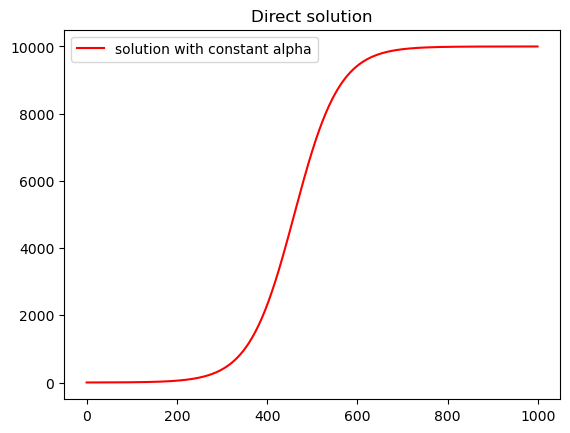

In [14]:
numpoints = 1000
timepoints = np.linspace(0,T,numpoints)

Y = solvey(parameters, 1.0)

fig, ax = plt.subplots()
ax.plot(Y,'r',label='solution with constant alpha')
ax.legend()
ax.set_title('Direct solution');

/var/folders/j7/_p_15hz14vg0xfymsqfnwlcm0000gn/T/ipykernel_88828/2849065695.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs[k,1] = Ytrue[int(iobs[k])]


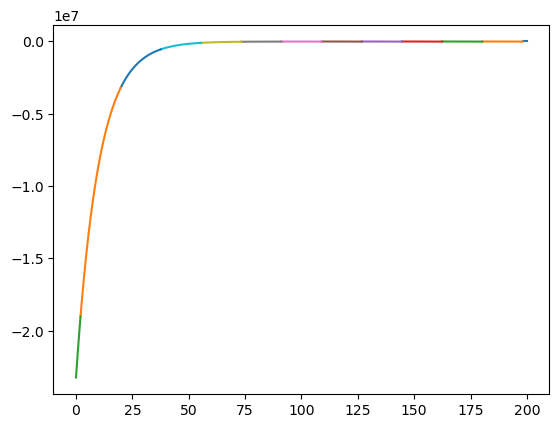

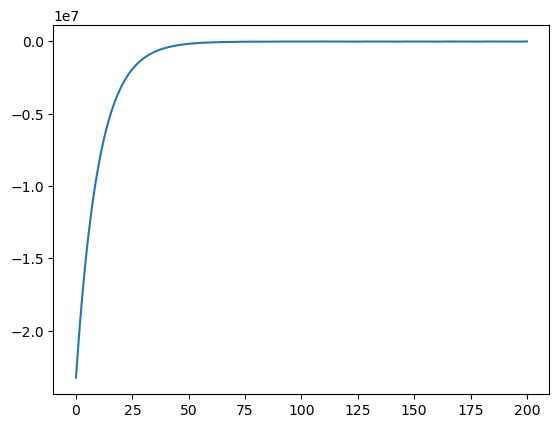

In [15]:
nobs = 12
iobs = np.floor(np.linspace(10,numpoints-10,nobs)) # index of observation times
obs = np.zeros((nobs,2))
obs[:,0] = iobs
Ytrue = solvey({'alpha':0.08,'K':2e3}, 1.0)
for k in range(nobs):
    obs[k,1] = Ytrue[int(iobs[k])]

# the cost function is j = sum_i (y(iobs)-obs[i])**2
p, tp = solveadj(parameters,Y,obs)

plt.figure()
plt.plot(tp,p);

0.01 0.1712201771500172
0.0001 -0.011471220406038945
1e-06 -0.012888467756995833
1e-08 -0.012902602323689834
1e-10 -0.012902784739039806
1e-12 -0.01291201880799799


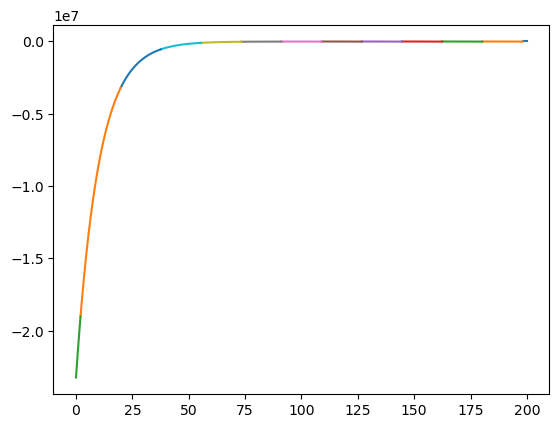

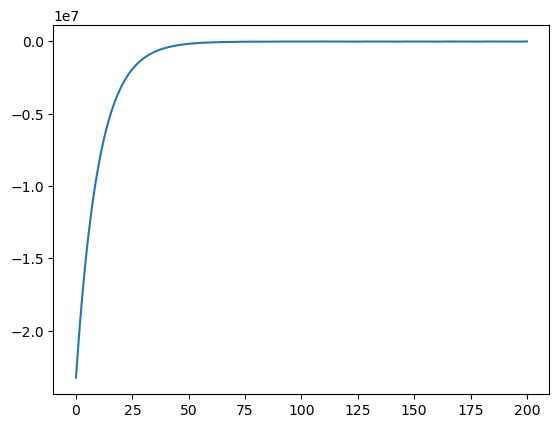

In [16]:
# the cost function is j = sum_i (y(iobs)-obs[i])**2
p, tp = solveadj(parameters,Y,obs)

plt.figure()
plt.plot(tp,p)
# caution: the adjoint p is the array of the values in the reverse order !
padj = p[::-1]

# computation of the gradient of j using the adjoint
# component along K
deltat = T/(numpoints-1)

gradjK = -deltat * np.sum(parameters['alpha']*Y[:,0]**2/parameters['K']**2*padj)
gradjalpha = -deltat*np.sum(Y[:,0]*(1-Y[:,0]/parameters['K'])*padj)
gradj = np.array([gradjalpha,gradjK])

# check the gradient :
# comparison of j(params+epsilon h) and j(params)+epsilon*(h,gradj)

j = 0.5*np.sum((Y[iobs.astype(int),0]-obs[:,1])**2)

h = np.random.randn(2)

for epsilon in [1e-2,1e-4,1e-6,1e-8,1e-10,1e-12]:
    parametersh = {'alpha':0.1+h[0]*epsilon, 'K':1e4+h[1]*epsilon}
    Yh = solvey(parametersh, 1.0)
    jh = 0.5*np.sum((Yh[iobs.astype(int),0]-obs[:,1])**2)
    difdiv = (jh-j)/epsilon
    res2 = np.vdot(h,gradj)
    print(epsilon,(difdiv-res2)/res2)